In [1]:
NAME = '01-lgb-1'
SEED = 489572034

In [2]:
import feather
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt

In [3]:
import os
from settings import *

In [17]:
import gc

#### Load data

In [4]:
d = feather.read_dataframe(os.path.join(DATA, 'processed', 'train_processed.feather'))

In [7]:
y = d['is_attributed']
# d.drop(['is_attributed', 'attributed_time'], axis=1, inplace=True)
d.drop(['is_attributed'], axis=1, inplace=True)

In [ ]:
test = feather.read_dataframe(os.path.join(DATA, 'processed', 'test_processed.feather'))

#### Feature eng

#### Training

In [9]:
d.head()

,ip,app,device,os,channel,quarter,time,date,day_of_week,week,n_ip_day_of_week_quarter_channel,n_ip_quarter_app_app,n_ip_quarter_device_device,n_ip_quarter_os_os,n_ip_quarter_channel_channel
0,83230,3,1,13,379,57,52341,20171106,0,45,1,47,255,43,4
1,17357,3,1,19,379,58,52414,20171106,0,45,1,40,205,44,6
2,35810,3,1,13,379,59,52452,20171106,0,45,1,43,147,42,2
3,45745,14,1,13,478,59,52492,20171106,0,45,1,278,3739,943,22
4,161007,3,1,13,379,60,52508,20171106,0,45,1,4,19,6,1


In [24]:
import time
import gc
# from sklearn.cross_validation import train_test_split
import lightgbm as lgb

In [15]:
categoricals = ['app', 'device', 'os', 'channel']

In [11]:
vars_name = ['app', 'device', 'os', 'channel', 'quarter', 'time', 'date',
       'day_of_week', 'week', 'n_ip_day_of_week_quarter_channel',
       'n_ip_quarter_app_app', 'n_ip_quarter_device_device',
       'n_ip_quarter_os_os', 'n_ip_quarter_channel_channel']

In [12]:
vars = np.where(d.columns.isin(vars_name))[0]

In [11]:
# vars = np.where(d.columns.isin(['app', 'device', 'os', 'channel', 'time', 'date', 'day_of_week', 'week']))[0]

In [12]:
# start_time = time.time()

# print('[{}] Starting LGBM Training'.format(time.time() - start_time))

# params = {
#     'num_leaves': 31,
#     'objective': 'binary',
#     'min_data_in_leaf': 200,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.85,
#     'bagging_freq': 3,
#     'metric': 'auc',
#     'num_threads': 4,
#     'scale_pos_weight':400
# }

# MAX_ROUNDS = 650

# N = 100000

# x1, x2, y1, y2 = train_test_split(d.iloc[:N, vars], y[:N], test_size=0.1, random_state=47840934)

# # del train, y
# gc.collect()

# dtrain = lgb.Dataset(x1, label=y1)
# dval = lgb.Dataset(x2, label=y2, reference=dtrain)

# del x1, x2, y1, y2
# gc.collect()

# model = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS, 
#                   categorical_feature=categoricals,
#                   valid_sets=[dtrain, dval], 
#                   early_stopping_rounds=50, 
#                   verbose_eval=10)


# del dtrain, dval
# gc.collect()

# print('[{}] Finished LGBM Training'.format(time.time() - start_time))

#### Optimise params here

In [18]:
from sklearn.model_selection import KFold

class Oversample(object):
    def __init__(self, X, y, n_splits=5, seed=None):
        
        self.ind0 = X.index[y==0]
        self.ind1 = X.index[y==1]
        
#         self.n_splits = n_splits
#         self.N_0 = 9 * len(ind1)
        
        self.kf_0 = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        self.kf_1 = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        
        self.non_event = self.kf_0.split(self.ind0)
        self.event = self.kf_1.split(self.ind1)
        

    def __next__(self):
        return self.generate()
    
    def generate(self):
        ind0_0, ind0_1 = next(self.non_event)
        ind1_0, ind1_1 = next(self.event)
        
        ind0_train = self.ind0[ind0_0]
        ind0_valid = self.ind0[ind0_1]
        
        ind1_train = self.ind1[ind1_0]
        ind1_valid = self.ind1[ind1_1]
        
        train = np.concatenate([np.random.choice(ind0_train, len(ind1_train) * 1), ind1_train])
        valid = np.concatenate([np.array(ind0_valid), np.array(ind1_valid)])
#         valid = np.concatenate([np.random.choice(ind0_valid, len(ind0_valid) * 9), ind1_valid])
        
        yield np.random.permutation(train), np.random.permutation(valid)

In [19]:
# y_0_index = d.index[y==0]
# y_1_index = d.index[y==1]
# ov = Oversample(y_0_index, y_1_index)

In [20]:
# ov = Oversample(y, seed=SEED)

In [21]:
# permutation = np.random.choice(d.index[y==0], size=y.sum()*9, replace=False)

# dtrain = lgb.Dataset(d.iloc[sample, vars], label=y.iloc[sample], categorical_feature=categoricals)


# x1, x2, y1, y2 = train_test_split(d.iloc[:N, vars], y[:N], test_size=0.1, random_state=47840934)
# dtrain = lgb.Dataset(x1, label=y1)
# dval = lgb.Dataset(x2, label=y2, reference=dtrain)


# dtrain = lgb.Dataset(d.iloc[:N, vars], label=y.iloc[:N], categorical_feature=categoricals)
# 
# gc.collect();

# del x1, x2, y1, y2
# gc.collect()

In [25]:
# permutation = np.random.choice(d.index[y==0], size=y.sum()*9, replace=False)

# N = 50000
N = d.shape[0]

# ov = Oversample(d.iloc[:N, vars], y[:N], seed=SEED)

dtrain = lgb.Dataset(d.iloc[:N, vars], label=y.iloc[:N], categorical_feature=categoricals)


# x1, x2, y1, y2 = train_test_split(d.iloc[:N, vars], y[:N], test_size=0.1, random_state=47840934)
# dtrain = lgb.Dataset(x1, label=y1)
# dval = lgb.Dataset(x2, label=y2, reference=dtrain)


# dtrain = lgb.Dataset(d.iloc[:N, vars], label=y.iloc[:N], categorical_feature=categoricals)

gc.collect();

# del x1, x2, y1, y2
# gc.collect()

In [26]:
ov = Oversample(d.iloc[:N, vars], y[:N], n_splits=5, seed=SEED)
gc.collect();

start_time = time.time()

print('[{}] Starting LGBM Training'.format(time.time() - start_time))

params = {
    'num_leaves': 131,
    'objective': 'binary',
    'min_data_in_leaf': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.63,
    'bagging_freq': 3,
    'metric': 'auc',
    'num_threads': 4,
    'scale_pos_weight':400
}

MAX_ROUNDS = 250

# N = d.shape[0]

# N = 10000


# model = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS, 
#                   valid_sets=[dtrain, dval], 
#                   early_stopping_rounds=50, 
#                   verbose_eval=10)

cv_auc = lgb.cv(params, dtrain, num_boost_round=MAX_ROUNDS, 
                folds = ov.generate(),
#                 nfold=5, 
                early_stopping_rounds=50, 
                verbose_eval=10, 
                seed=SEED)

cv_auc_mean = pd.DataFrame(cv_auc)['auc-mean'].mean()

# del dtrain#, dval
gc.collect()

print('[{}] Finished LGBM Training'.format(time.time() - start_time))

[4.887580871582031e-05] Starting LGBM Training


/Users/toniblaslov/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[10]	cv_agg's auc: 0.96655 + 0
[20]	cv_agg's auc: 0.967138 + 0
[30]	cv_agg's auc: 0.967526 + 0
[40]	cv_agg's auc: 0.968456 + 0
[50]	cv_agg's auc: 0.96892 + 0
[60]	cv_agg's auc: 0.9694 + 0
[70]	cv_agg's auc: 0.969779 + 0
[80]	cv_agg's auc: 0.970278 + 0
[90]	cv_agg's auc: 0.970816 + 0
[100]	cv_agg's auc: 0.971279 + 0
[110]	cv_agg's auc: 0.971523 + 0
[120]	cv_agg's auc: 0.971771 + 0
[130]	cv_agg's auc: 0.972269 + 0
[140]	cv_agg's auc: 0.972602 + 0
[150]	cv_agg's auc: 0.973105 + 0
[160]	cv_agg's auc: 0.973456 + 0
[170]	cv_agg's auc: 0.973747 + 0
[180]	cv_agg's auc: 0.973949 + 0
[190]	cv_agg's auc: 0.974085 + 0
[200]	cv_agg's auc: 0.974223 + 0
[210]	cv_agg's auc: 0.974297 + 0
[220]	cv_agg's auc: 0.974352 + 0
[230]	cv_agg's auc: 0.974411 + 0
[240]	cv_agg's auc: 0.974408 + 0
[250]	cv_agg's auc: 0.974438 + 0
[260]	cv_agg's auc: 0.974492 + 0
[270]	cv_agg's auc: 0.974525 + 0
[280]	cv_agg's auc: 0.974525 + 0
[290]	cv_agg's auc: 0.974535 + 0
[300]	cv_agg's auc: 0.974529 + 0
[310]	cv_agg's auc: 0.9

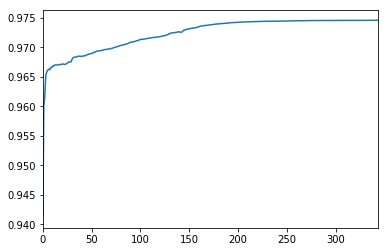

In [27]:
pd.DataFrame(cv_auc)['auc-mean'].plot();

#### Fit final model here

In [ ]:
start_time = time.time()

print('[{}] Starting LGBM Training'.format(time.time() - start_time))

# params = {
#     'num_leaves': 31,
#     'objective': 'binary',
#     'min_data_in_leaf': 200,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.85,
#     'bagging_freq': 3,
#     'metric': 'auc',
#     'num_threads': 4,
#     'scale_pos_weight':400
# }

# MAX_ROUNDS = 650

model = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS, 
                  categorical_feature=categoricals,
                  valid_sets=[dtrain], 
                  early_stopping_rounds=50, 
                  verbose_eval=10)


# del dtrain#, dval
gc.collect()

print('[{}] Finished LGBM Training'.format(time.time() - start_time))

#### Score and save to outputs

In [ ]:
y_test = model.predict(test.loc[:,vars_name])

In [ ]:
d_sub = pd.DataFrame({'click_id': range(len(y_test)), 'is_attributed': y_test})

In [ ]:
# y_test = model.predict(test.loc[:,vars])

In [ ]:
# d_sub.to_csv(os.path.join(OUTPUT, NAME + '-' + str(cv_auc_mean) + '.csv'), index=False)
feather.write_dataframe(d_sub, os.path.join(OUTPUT, NAME + '-' + str(cv_auc_mean) + '.feather'))

#### Save the model to disk

In [ ]:
import pickle
with open(os.path.join(ROOT, 'models', NAME + '.pickle'), 'wb') as file:
    pickle.dump(model, file)